In [46]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

# Load data
df = pd.read_csv("data.csv")

In [47]:
# Data cleaning
# Remove extreme outliers (cars priced over $200k)
df = df[df['MSRP'] < 200_000]

# Handle missing values
df = df.dropna(subset=['Engine HP', 'MSRP', 'city mpg'])
df['Market Category'] = df['Market Category'].fillna('Unknown')

# Feature engineering
df['Age'] = 2023 - df['Year']
df['HP_per_cylinder'] = df['Engine HP'] / df['Engine Cylinders'].replace(0, 1)  # Avoid division by zero
df['log_MSRP'] = np.log(df['MSRP'])  # Log-transform target

In [48]:
# Select features
features = [
    'Engine HP', 'city mpg', 'Age', 'HP_per_cylinder',
    'Make', 'Vehicle Size', 'Transmission Type', 'Driven_Wheels'
]

In [49]:
# Preprocessing
X = pd.get_dummies(df[features], drop_first=True)
y = df['log_MSRP']  # Use log-transformed target

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [50]:
# Train XGBoost model with tuned parameters
model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [51]:
# Evaluate
y_pred_log = model.predict(X_test)
y_pred = np.exp(y_pred_log)  # Convert back to original scale
y_test_exp = np.exp(y_test)

print(f"MAE: ${mean_absolute_error(y_test_exp, y_pred):,.2f}")
print(f"R²: {r2_score(y_test_exp, y_pred):.2f}")

MAE: $2,914.43
R²: 0.96


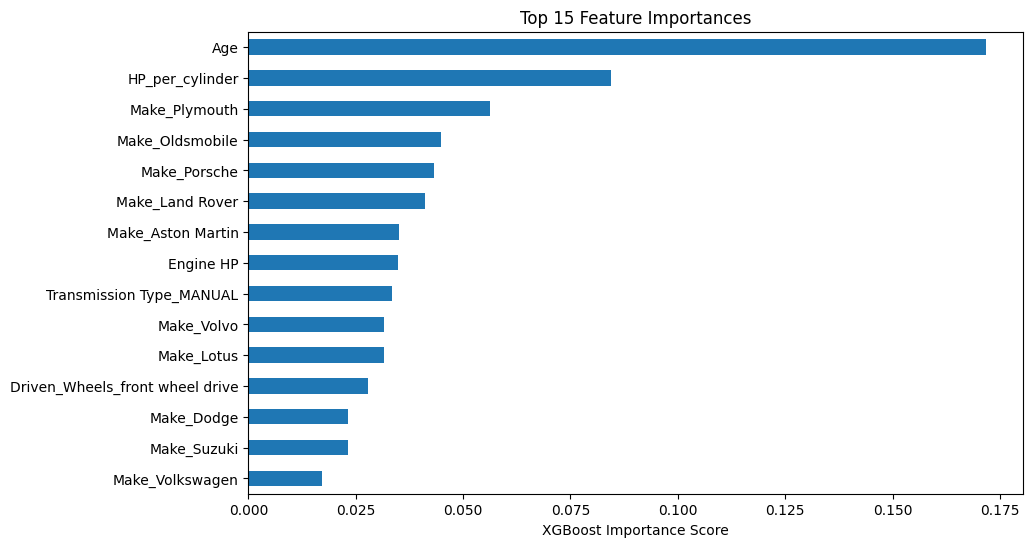

In [52]:
# Feature importance
importance = pd.Series(model.feature_importances_, index=X.columns)
plt.figure(figsize=(10, 6))
importance.nlargest(15).sort_values().plot(kind='barh')
plt.title('Top 15 Feature Importances')
plt.xlabel('XGBoost Importance Score')
plt.show()

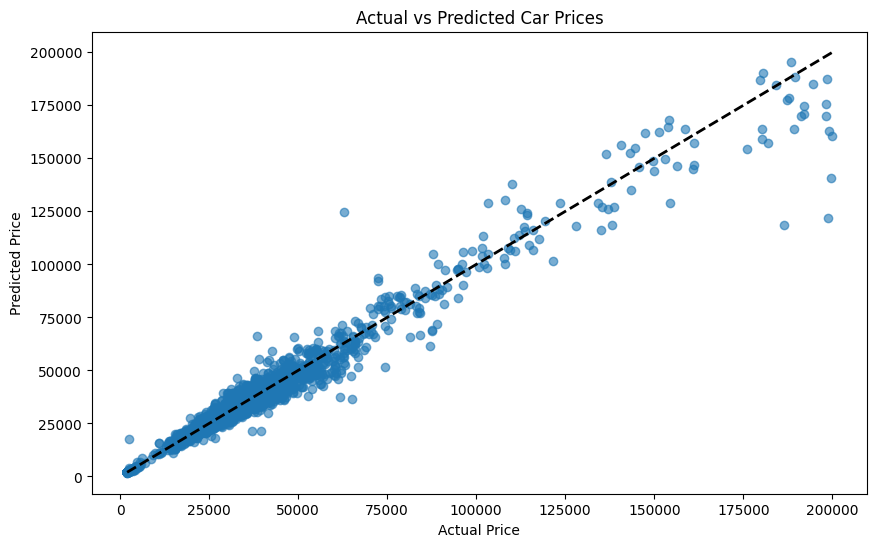

In [53]:
# Actual vs Predicted plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test_exp, y_pred, alpha=0.6)
plt.plot([y_test_exp.min(), y_test_exp.max()], 
         [y_test_exp.min(), y_test_exp.max()], 'k--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Car Prices')
plt.show()

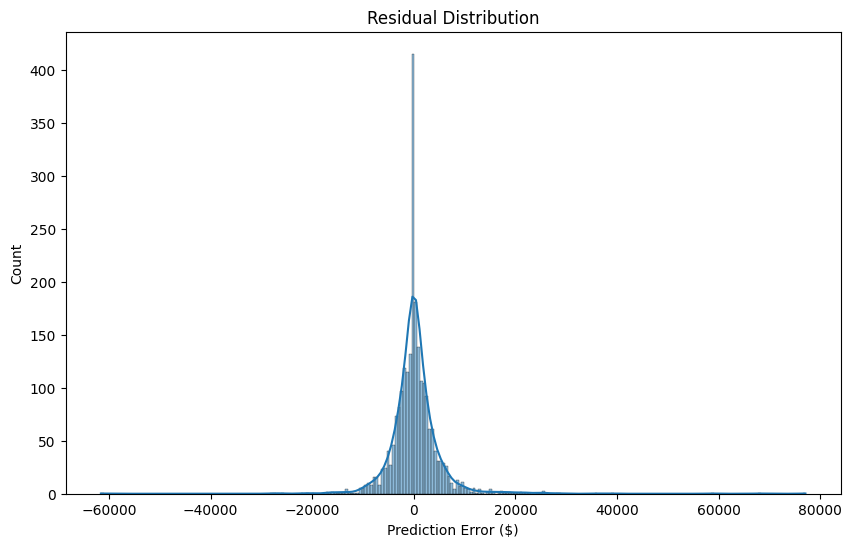

In [54]:
# Residual analysis
residuals = y_test_exp - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Residual Distribution')
plt.xlabel('Prediction Error ($)')
plt.show()

In [55]:
# After predictions, map back to original data using indices
test_indices = X_test.index  # Get the indices of the test set
df_test = df.loc[test_indices, ['Make', 'Model']].copy()  # Pull original 'Make' and 'Model'
df_test['Actual'] = y_test_exp  # Actual prices
df_test['Predicted'] = y_pred   # Model predictions

# Calculate pricing gap
df_test['Pricing Gap (%)'] = ((df_test['Actual'] - df_test['Predicted']) / df_test['Predicted']) * 100

# Top 10 underpriced cars
print(df_test.sort_values('Pricing Gap (%)').head(10))

                Make                Model   Actual      Predicted  \
3575      Land Rover  Discovery Series II   2561.0   17516.070312   
2061   Mercedes-Benz              C-Class  62950.0  124528.789062   
9410             GMC            Sierra C3  38370.0   66285.070312   
532    Mercedes-Benz            500-Class   2427.0    4045.760010   
10092        Pontiac              Sunfire  10895.0   15749.337891   
10089        Pontiac              Sunfire  10895.0   15734.055664   
4691         Pontiac             Firebird   6175.0    8900.906250   
11485            BMW                   X1  39100.0   55339.945312   
47               BMW             2 Series  32850.0   46324.148438   
759              BMW             8 Series   4784.0    6689.734863   

       Pricing Gap (%)  
3575        -85.379141  
2061        -49.449440  
9410        -42.113662  
532         -40.011271  
10092       -30.822489  
10089       -30.755298  
4691        -30.625042  
11485       -29.345792  
47          -29